# Bug 1728210: symbol upload timings

We're in the process of removing celery from our infrastructure. There was one celery task that was kicked off at the end of handling symbol upload API requests which updated bookkeeping in the database. One of the changes in bug 1728210 was to move the work that task did into the end of the symbol upload API view code.

This notebook looks at how that change affected symbol upload request handling timings.

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import datetime

I pulled the data from Grafana for `tecken.upload_archive` means with an interval of 1h from 2021-09-22 to 2021-10-08. I downloaded this as a CSV.

Text(0, 0.5, 'timing (ms)')

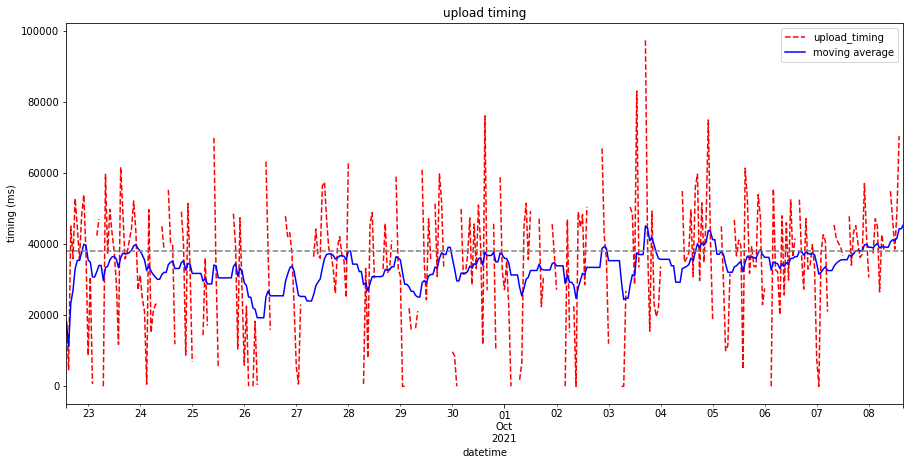

In [2]:
# Data file is a csv with [datetime, timing (ms)];
#
# Note: Path is dependent on this notebook running in the Docker container.
data = pd.read_csv("./work/notebooks/data/upload_archive_times_20211001.csv")
data["datetime"] = pd.to_datetime(data["Time"], unit="ms", utc=True)
data["upload_timing"] = pd.to_numeric(data["tecken.upload_archive.mean"])

# print(data["datetime"].to_string())

input_data = data[["datetime", "upload_timing"]]
first_date = input_data["datetime"].min()
last_date = input_data["datetime"].max()
input_data.set_index("datetime", inplace=True)

df = input_data["upload_timing"]
df.plot(style="r--", xlabel="datetime", ylabel="timing (ms)", figsize=(15, 7))
df.ewm(span=24).mean().plot(style="b", label="moving average")

plt.legend()
plt.axhline(y=38000, linestyle="--", color="gray")
plt.title("upload timing")
plt.xlabel("datetime")
plt.ylabel("timing (ms)")

# Thoughts

There should be an increase in how long it takes the view to complete starting on October 1st because the view is doing more work.

I think this confirms there is an increase and that it is noticeable, but that it's not such a big increase that we should roll back the change.